In [12]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display
from IPython.core.pylabtools import figsize
from __future__ import print_function

# import json
# import matplotlib
# s = json.load(open("../../styles/bmh_matplotlibrc.json"))
# matplotlib.rcParams.update(s)

import os
import sys
import glob
import time
import numpy as np
import numpy.random as nr

import keras
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Input, Flatten, Dropout, Lambda
from keras.layers import Conv2D, MaxPooling2D, Embedding
from keras.layers.normalization import BatchNormalization
from keras.models import Model, load_model
from keras.optimizers import (SGD, 
                              RMSprop, 
                              Adam, 
                              Adadelta, 
                              Adagrad)

sys.path.append('../src')
from my_keras_utilities import (get_available_gpus, 
                                load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

os.makedirs('../../models',exist_ok=True)
np.set_printoptions(precision=3, linewidth=120, suppress=True)

In [13]:
import keras.backend as K
K.set_floatx('float32')

print('Backend:        {}'.format(K.backend()))
print('Data format:    {}'.format(K.image_data_format()))
print('Available GPUS:', get_available_gpus())

Backend:        tensorflow
Data format:    channels_last
Available GPUS: ['/gpu:0']


In [14]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


In [15]:
# http://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/

batch_size = 100
flatten_dim = 784
latent_dim = 2
intermediate_dim = 512

# Q(z|X) -- encoder
inputs     = Input(shape=(flatten_dim,))
enc_hidden = Dense(intermediate_dim, activation='relu')(inputs)
enc_mean   = Dense(latent_dim, activation='linear')(enc_hidden)
enc_logvar = Dense(latent_dim, activation='linear')(enc_hidden)

def sample_z(args, batch_size=batch_size, latent_dim=latent_dim):
    enc_mean, enc_logvar = args
    # para usar a linha seguinte é preciso especificar batch_shape em Input
    # eps = K.random_normal(shape=enc_mean.shape, mean=0.0, stddev=1.0)
    eps = K.random_normal(shape=(batch_size, latent_dim), mean=0.0, stddev=1.0)
    return enc_mean + K.exp(enc_logvar / 2) * eps

# Sample z ~ Q(z|X)
enc_sampled = Lambda(sample_z)([enc_mean, enc_logvar])

# P(X|z) -- decoder
decoder_hidden_layer = Dense(intermediate_dim, activation='relu')
decoder_output_layer = Dense(flatten_dim, activation='sigmoid')

dec_hidden = decoder_hidden_layer(enc_sampled)
outputs    = decoder_output_layer(dec_hidden)

# Overall VAE model, for reconstruction and training
vae = Model(inputs, outputs)

# Encoder model, to encode input into latent variable
# We use the mean as the output as it is the center point, the representative of the gaussian
encoder = Model(inputs, enc_mean)

# Generator model, generate new data given latent variable z
dec_in  = Input(shape=(latent_dim,))
dec_h   = decoder_hidden_layer(dec_in)
dec_out = decoder_output_layer(dec_h)
decoder = Model(dec_in, dec_out)


In [16]:
def vae_loss(y_true, y_pred, mean=enc_mean, logvar=enc_logvar):
    """ Calculate loss = reconstruction loss + KL loss for each data in minibatch """
    # E[log P(X|z)]
    recon = K.sum(K.binary_crossentropy(y_pred, y_true), axis=1)
    
    # Kullback–Leibler divergence
    # calculate in closed form as both dist. are Gaussian
    kl = 0.5 * K.sum(K.exp(logvar) + K.square(mean) - 1. - logvar, axis=1)

    return recon + kl


In [77]:
from keras.callbacks import Callback
class MyCb(Callback):
    def __init__(self, n):
        self.n = n
        self.t0 = time.time()
    
    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.n == 0:
            print('{:5d}: {:.5f}  {:.5f}  [{:.2f}s]'.format(epoch, logs['loss'], logs['val_loss'], time.time() - self.t0))
            self.t0 = time.time()


trainIt = 1
model_weights_fn = '../../models/vae_mnist_01.weights'

if os.path.isfile(model_weights_fn):
    vae.load_weights(model_weights_fn)

vae.compile(optimizer=Adam(), loss=vae_loss)

if trainIt:
    nb_epochs = 1000

    log = MyCb(50)
    ckp = ModelCheckpoint(model_weights_fn, monitor='val_loss', verbose=0,
                          save_weights_only=True, save_best_only=True, mode='min')

    try:
        vae.fit(x_train, x_train, batch_size=batch_size, epochs=nb_epochs, 
                verbose=0, validation_data=(x_test, x_test), callbacks=[log, ckp])
    except KeyboardInterrupt:
        print("Interrupted!")

    0: 141.91617  149.41658  [5.27s]
   50: 140.66835  149.83320  [216.74s]
  100: 139.81785  150.04814  [216.47s]
  150: 139.17832  150.40153  [217.09s]
  200: 138.64982  150.57992  [217.57s]
  250: 138.24497  151.13477  [217.29s]
Interrupted!


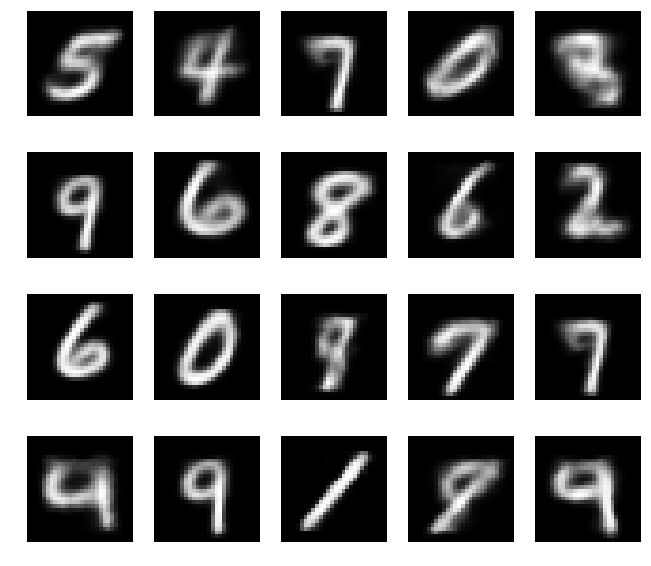

In [78]:
bs = 20
samples = nr.normal(0.0, 1.0, size=(bs, latent_dim))
aa = decoder.predict(samples, batch_size=bs)
bb = aa.reshape(bs, 28, 28)

figsize(11, 10)
for i, img in enumerate(bb):
    plot.subplot(4, 5, i+1)
    plot.imshow(img, cmap=plot.cm.gray)
    plot.axis('off')    

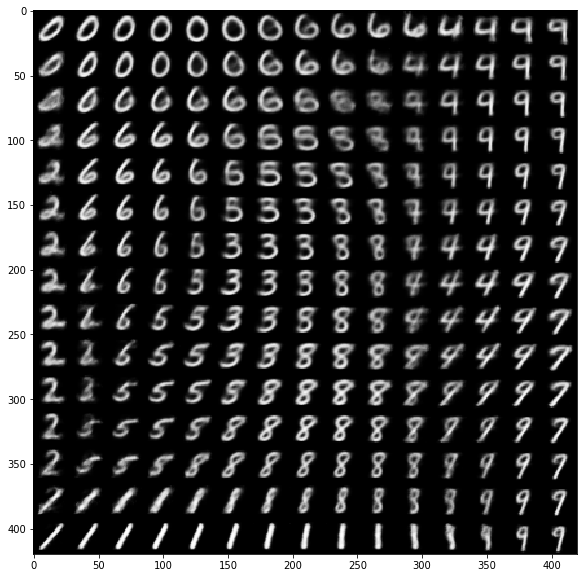

In [79]:
from scipy.stats import norm
nh, nw = 15, 15
hh, ww = 28, 28
figure = np.zeros((hh * nh, ww * nw))

# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, nw))
grid_y = norm.ppf(np.linspace(0.05, 0.95, nh))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        face = x_decoded[0].reshape(28, 28)
        figure[j * hh: (j + 1) * hh, i * ww: (i + 1) * ww] = face

plot.figure(figsize=(20, 10))
plot.imshow(figure, cmap='gray')


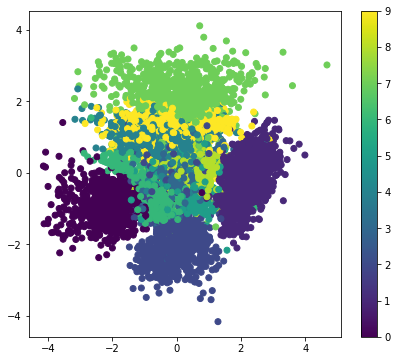

In [80]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plot.figure(figsize=(7, 6))
plot.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plot.colorbar()


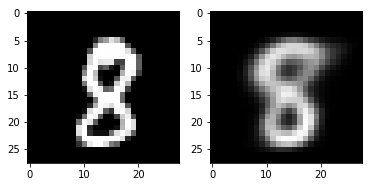

In [93]:
m = nr.randint(10000)
img = vae.predict(x_test[m:m+batch_size], batch_size=batch_size)

figsize(6, 3)
plot.subplot(1, 2, 1)
plot.imshow(x_test[m].reshape(28, 28), cmap='gray')
plot.subplot(1, 2, 2)
plot.imshow(img[0].reshape(28, 28), cmap='gray')

[[ 0.474 -0.095]] [[ 0.954  0.419]]


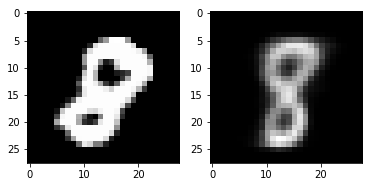

In [86]:
m = nr.randint(10000)
img = x_test[m].reshape(1, -1)
code = encoder.predict(img, batch_size=1)

sampled = nr.normal(code, 1)
print(code, sampled)

img1 = x_test[m].reshape(28, 28)
img2 = decoder.predict(sampled).reshape(img1.shape)

figsize(6, 3)
plot.subplot(1, 2, 1)
plot.imshow(img1, cmap='gray')
plot.subplot(1, 2, 2)
plot.imshow(img2, cmap='gray')